<a href="https://colab.research.google.com/github/SCCSMARTCODE/Deep-Learning-00/blob/main/FashionMNIST/FashionMNIST_vs1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cifar 100 project**

In [ ]:
import torchvision
import matplotlib.pyplot as plt
from torch import nn
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.optim import SGD
import random
import os

PATH="/content/drive/MyDrive/Deep Learning/fashionMNIST/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("CPU is available")

GPU is available


In [ ]:

raw_training_dataset = torchvision.datasets.FashionMNIST(root=PATH, transform=torchvision.transforms.ToTensor(), train=True)
raw_testing_dataset = torchvision.datasets.FashionMNIST(root=PATH, transform=torchvision.transforms.ToTensor(), train=False)

train_dataset, val_dataset = random_split(raw_training_dataset, [55000, 5000])
train_loader = DataLoader(train_dataset, batch_size=12000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)
testing_loader =  DataLoader(raw_testing_dataset, batch_size=128, shuffle=True)

In [ ]:
print(len(val_dataset))

print(val_dataset[0])

In [ ]:
class FashionMNIST(nn.Module):

    def __init__(self, sizes=[28*28, 16, 32, 10]):
        self.sizes = sizes
        super(FashionMNIST, self).__init__()
        self.function_packs = nn.ModuleList()
        self.activation = nn.functional.relu
        self.loss_function = nn.CrossEntropyLoss(reduction='mean')
        for x in range(len(sizes[:-1])):
            self.function_packs.append(nn.Linear(sizes[x], sizes[x+1]))

    def forward(self, input):
        input = input.reshape(-1, self.sizes[0])
        for x, function in enumerate(self.function_packs):
            input = function(input)
            if x != len(self.function_packs) - 1:
                input = self.activation(input)
        return torch.nn.functional.softmax(input, dim=1)

    def training_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        pred = self(images)
        loss = self.loss_function(pred, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        pred = self(images)
        # print(pred[:2], labels[:2])
        loss = self.loss_function(pred, labels)
        acc = self.accuracy(pred, labels)
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.tensor(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    @staticmethod
    def accuracy(pred, labels):
        right_pred_count = 0
        indices = torch.max(pred, dim=1)[1]
        for index, label in zip(indices, labels):
            if index == label:
                right_pred_count += 1
        return right_pred_count / len(labels)


    def epoch_end(self, epoch, result):
        print('Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}'.format(epoch, result['val_loss'], result['val_acc']))


model = FashionMNIST()
model.to(device)

FashionMNIST(
  (function_packs): ModuleList(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
  (loss_function): CrossEntropyLoss()
)

In [ ]:
print(model.state_dict())

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
def train(epochs, lr, model, train_loader, val_loader, opt=SGD):
    history = []
    optimizer = opt(model.parameters(), lr)
    for epoch in range(epochs):
    # batch training
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        #validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        torch.save(model.state_dict(), os.path.join(PATH, "parameters_fully_connected.pth"))
    return history


In [ ]:
result0 = evaluate(model, val_loader)
print(result0)

{'val_loss': 1.731331467628479, 'val_acc': 0.7373046875}


In [ ]:
# model.load_state_dict(torch.load(os.path.join(PATH, "parameters.pth"), map_location=device))

<All keys matched successfully>

In [ ]:
history1 = train(5, 0.52, model, train_loader, val_loader)

Epoch [0], val_loss: 2.2988, val_acc: 0.1045
Epoch [1], val_loss: 2.2959, val_acc: 0.1066
Epoch [2], val_loss: 2.2922, val_acc: 0.1379
Epoch [3], val_loss: 2.2879, val_acc: 0.2148
Epoch [4], val_loss: 2.2829, val_acc: 0.2652


In [ ]:
history1.extend(train(50, 0.02, model, train_loader, val_loader))

Epoch [0], val_loss: 1.7327, val_acc: 0.7350
Epoch [1], val_loss: 1.7397, val_acc: 0.7293
Epoch [2], val_loss: 1.7375, val_acc: 0.7295
Epoch [3], val_loss: 1.7307, val_acc: 0.7387
Epoch [4], val_loss: 1.7386, val_acc: 0.7301
Epoch [5], val_loss: 1.7378, val_acc: 0.7301
Epoch [6], val_loss: 1.7324, val_acc: 0.7359
Epoch [7], val_loss: 1.7328, val_acc: 0.7359
Epoch [8], val_loss: 1.7384, val_acc: 0.7301
Epoch [9], val_loss: 1.7359, val_acc: 0.7330
Epoch [10], val_loss: 1.7349, val_acc: 0.7330
Epoch [11], val_loss: 1.7397, val_acc: 0.7271
Epoch [12], val_loss: 1.7378, val_acc: 0.7303
Epoch [13], val_loss: 1.7412, val_acc: 0.7244
Epoch [14], val_loss: 1.7355, val_acc: 0.7332
Epoch [15], val_loss: 1.7349, val_acc: 0.7332
Epoch [16], val_loss: 1.7350, val_acc: 0.7332
Epoch [17], val_loss: 1.7386, val_acc: 0.7303
Epoch [18], val_loss: 1.7378, val_acc: 0.7303
Epoch [19], val_loss: 1.7379, val_acc: 0.7301
Epoch [20], val_loss: 1.7377, val_acc: 0.7303
Epoch [21], val_loss: 1.7347, val_acc: 0.733

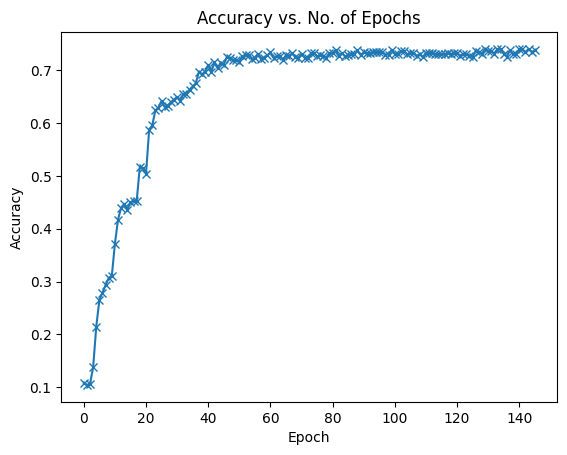

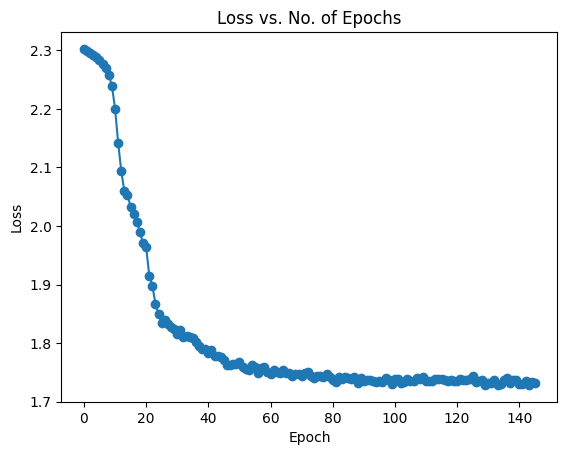

In [ ]:
history = [result0] + history1
accuracies = [result['val_acc'] for result in history]
losses = [result['val_loss'] for result in history]

# Plot for Accuracy
plt.figure(1)
plt.plot(accuracies, '-x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. No. of Epochs')

# Plot for Loss
plt.figure(2)
plt.plot(losses, '-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. No. of Epochs')

plt.show()

In [ ]:
for images, labels in testing_loader:
    images = images.to(device)
    labels = labels.to(device)
    pred = model(images)
    for x, y in zip(pred, labels):
        pred, index = torch.max(x, dim=0)
        print(f"->Assign {pred * 100:.1f}% prob for {raw_training_dataset.classes[index.data]} -------- {raw_training_dataset.classes[y]}")
    break

->Assign 100.0% prob for Dress -------- Dress
->Assign 99.9% prob for Trouser -------- Trouser
->Assign 100.0% prob for Pullover -------- Coat
->Assign 100.0% prob for T-shirt/top -------- Shirt
->Assign 54.7% prob for Sneaker -------- Ankle boot
->Assign 50.0% prob for T-shirt/top -------- Shirt
->Assign 100.0% prob for Sandal -------- Sandal
->Assign 99.6% prob for Ankle boot -------- Ankle boot
->Assign 100.0% prob for Trouser -------- Trouser
->Assign 100.0% prob for Pullover -------- Pullover
->Assign 96.2% prob for Sneaker -------- Sneaker
->Assign 100.0% prob for Sneaker -------- Sneaker
->Assign 100.0% prob for Pullover -------- Coat
->Assign 89.9% prob for Dress -------- Dress
->Assign 100.0% prob for T-shirt/top -------- T-shirt/top
->Assign 100.0% prob for T-shirt/top -------- T-shirt/top
->Assign 99.6% prob for Sneaker -------- Sneaker
->Assign 100.0% prob for Pullover -------- Pullover
->Assign 100.0% prob for T-shirt/top -------- Shirt
->Assign 100.0% prob for Pullover --